<a href="https://colab.research.google.com/github/Shafna81/fakenewsdetection/blob/main/IndoBERT_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install sentencepiece
import sentencepiece
import torch.nn.functional as F
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import torch
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, BertTokenizerFast, BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import get_linear_schedule_with_warmup
import time
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.1 MB/s eta 0:00:00


In [ ]:
!pip install session-info

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.6 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=b2d6a6ccc252f783d9a8e7ebf8fe1d6858f498a2aec337f75cc9dbea0d5ab9fb
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
import session_info
session_info.show()

In [ ]:
!pip freeze > requirements.txt
!pip list --format=freeze > requirements.txt

In [ ]:
seed = 12
torch.manual_seed(seed)

In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/SKRIPSI/dataset.csv')
df.head()

,Label,Text
0,1,pertamina pemerintah kalrifikasi isu bbm naik ...
1,1,polda nusa tenggara barat mengklarifkasi kejad...
2,1,pt ultrajaya milk industry tbk mengklarifikasi...
3,1,bbksda jatim mengklarifikasi wisata alam kawah...
4,1,bmkg mataram menghimbau warga langsung percaya...


In [ ]:
# split dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Text'].tolist(), df['Label'].tolist(), test_size=0.2, random_state=42)

In [ ]:
# load model BERT Indonesia yang telah dilatih sebelumnya
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dropout_rate = 0.5
model.config.hidden_dropout_prob = dropout_rate
model.config.attention_probs_dropout_prob = dropout_rate

In [ ]:
# Tokenize training texts
train_tokenized_texts = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Tokenize test texts
test_tokenized_texts = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")


# Create tensors for labels
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

In [ ]:
# Bagi dataset menjadi data training dan data testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


train_encodings = tokenizer(train_df['Text'].tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_df['Text'].tolist(), truncation=True, padding=True, max_length=512)

# Konversi data ke dalam format tensor
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']),
                                               torch.tensor(train_encodings['attention_mask']),
                                               torch.tensor(train_df['Label'].tolist()))

test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']),
                                              torch.tensor(test_encodings['attention_mask']),
                                              torch.tensor(test_df['Label'].tolist()))

In [ ]:
# set device to CUDA if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# set training parameters
optimizer = Adam(model.parameters(), lr=2e-5, eps=1e-8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
total_steps = len(train_loader) * 2

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss()

#loss tiap epoch
loss_training = []
acurracy_training = []
f1_score_training = []

loss_testing = []
accuracy_testing = []
f1_score_testing = []

start_time = time.time()

for epoch in range(10):
    print('\nEpoch:', epoch+1)
    print('Training...')
    model.train()

    total_loss = 0

    for step, batch in enumerate(train_loader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        total_loss += loss.item()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        if step % 500 == 0 and step != 0:
            avg_train_loss = total_loss / 500
            print('Batch', step, 'of', len(train_loader), '| Average Training Loss:', avg_train_loss)
            total_loss = 0

    loss_training.append (total_loss)
    print('loss:', loss_training)


    print('Testing...')
    model.eval()

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

    predictions = []
    true_labels = []
    total_loss = 0

    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        predictions.extend(preds.cpu().numpy().tolist())
        true_labels.extend(labels.cpu().numpy().tolist())

        total_loss += loss.item()

    loss_testing.append (total_loss)

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print('\nAccuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)

    accuracy_testing.append(accuracy)
    f1_score_testing.append(f1)

    end_time = time.time()
    runtime = end_time - start_time

    print(f"Waktu runtime: {runtime} detik")


Epoch: 1
Training...
loss: [49.931552708148956]
Testing...

Accuracy: 0.8400900900900901
Precision: 0.8333333333333334
Recall: 0.812807881773399
F1 Score: 0.8229426433915211
Waktu runtime: 181.11756205558777 detik

Epoch: 2
Training...
loss: [49.931552708148956, 24.05943327769637]
Testing...

Accuracy: 0.8581081081081081
Precision: 0.8097345132743363
Recall: 0.9014778325123153
F1 Score: 0.8531468531468532
Waktu runtime: 362.7226586341858 detik

Epoch: 3
Training...
loss: [49.931552708148956, 24.05943327769637, 16.575689528137445]
Testing...

Accuracy: 0.8581081081081081
Precision: 0.8097345132743363
Recall: 0.9014778325123153
F1 Score: 0.8531468531468532
Waktu runtime: 544.2562251091003 detik

Epoch: 4
Training...
loss: [49.931552708148956, 24.05943327769637, 16.575689528137445, 16.416560735553503]
Testing...

Accuracy: 0.8581081081081081
Precision: 0.8097345132743363
Recall: 0.9014778325123153
F1 Score: 0.8531468531468532
Waktu runtime: 725.78196144104 detik

Epoch: 5
Training...
los

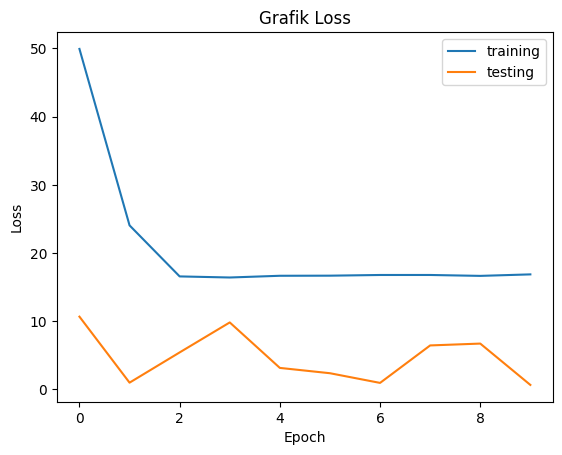

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_training, label="training")
plt.plot(loss_testing, label="testing")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Grafik Loss')
plt.legend()

Text(0.5, 1.0, 'Grafik Akurasi Testing')

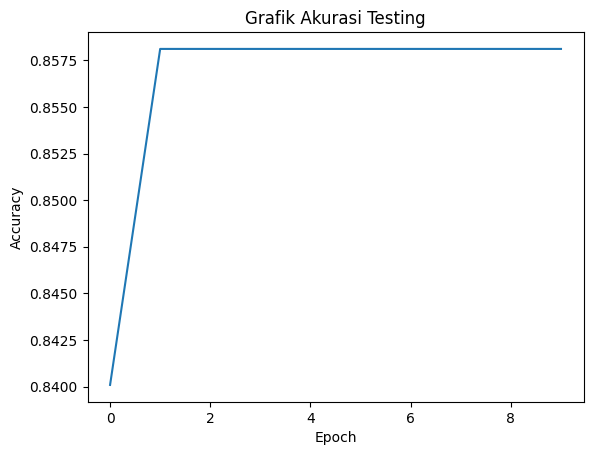

In [ ]:
plt.figure()
plt.plot(accuracy_testing)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Grafik Akurasi Testing')

Text(0.5, 1.0, 'Grafik F1 Score Testing')

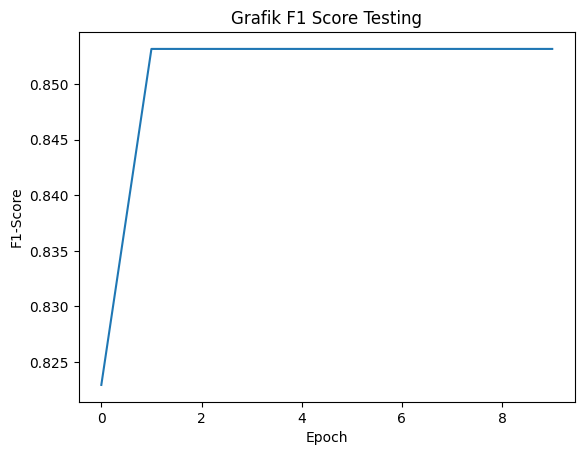

In [ ]:
plt.figure()
plt.plot(f1_score_testing)
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Grafik F1 Score Testing')

In [ ]:
tabel_hasil = pd.DataFrame(range(1, 11), columns=['ke-'])
tabel_hasil["loss_training"] = loss_training
tabel_hasil["loss_testing"] = loss_testing
tabel_hasil["accuracy"] = accuracy_testing
tabel_hasil["F1-Score"] = f1_score_testing
tabel_hasil["recall"] = accuracy_testing
tabel_hasil["precision"] = f1_score_testing

In [ ]:
tabel_hasil.head()

,ke-,loss_training,loss_testing,accuracy,F1-Score,recall,precision
0,1,49.931553,10.674721,0.840090,0.822943,0.840090,0.822943
1,2,24.059433,0.997453,0.858108,0.853147,0.858108,0.853147
2,3,16.575690,5.432539,0.858108,0.853147,0.858108,0.853147
3,4,16.416561,9.827946,0.858108,0.853147,0.858108,0.853147
4,5,16.669203,3.159968,0.858108,0.853147,0.858108,0.853147


In [ ]:
tabel_hasil.to_csv("12BERT datasetjibran, adam, 2e-5, bs 16, 10 epoch.csv")